In [1]:
from cnn.model import build_net

from spleen_dataset.dataloader import SpleenDataloader, SpleenDataset, get_training_augmentation, get_validation_augmentation
from spleen_dataset.config import dataset_folder
from spleen_dataset.utils import get_split_deterministic, get_list_of_patients

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import random
import numpy as np

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    #tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6400)])
    tf.config.experimental.set_memory_growth(gpus[0], False)
  except RuntimeError as e:
    print(e)

2022-09-23 12:25:03.688328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 12:25:03.756922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 12:25:03.757049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
patients = get_list_of_patients(dataset_folder)

In [3]:
patch_size = (128, 128)
batch_size = 32
num_classes = 2
train_augmentation = get_training_augmentation(patch_size)
val_augmentation = get_validation_augmentation(patch_size)

net_list = [
    'vgg_3_32', 
    'vgg_3_64',
    'vgg_3_128',
    'vgg_3_256',
    'vgg_3_512',
    'vgg_3_256',
    'vgg_3_128',
    'vgg_3_64',
    'vgg_3_32'
]


fn_dict = {
    'vgg_3_32':       {'block': 'VGGBlock',      'params': {'kernel': 3, 'filters': 32},   'prob': 1/36},
    'vgg_3_64':       {'block': 'VGGBlock',      'params': {'kernel': 3, 'filters': 64},   'prob': 1/36},
    'vgg_3_128':      {'block': 'VGGBlock',      'params': {'kernel': 3, 'filters': 128},  'prob': 1/36},
    'vgg_3_256':      {'block': 'VGGBlock',      'params': {'kernel': 3, 'filters': 256},  'prob': 1/36},
    'vgg_3_512':      {'block': 'VGGBlock',      'params': {'kernel': 3, 'filters': 512},  'prob': 1/36},
    'vgg_3_1024':     {'block': 'VGGBlock',      'params': {'kernel': 3, 'filters': 1024}, 'prob': 1/36},
    # 'resnet_3_32':    {'block': 'ResNetBlock',   'params': {'kernel': 3, 'filters': 32},   'prob': 1/36},
    # 'resnet_3_64':    {'block': 'ResNetBlock',   'params': {'kernel': 3, 'filters': 64},   'prob': 1/36},
    # 'resnet_3_128':   {'block': 'ResNetBlock',   'params': {'kernel': 3, 'filters': 128},  'prob': 1/36},
    # 'resnet_3_256':   {'block': 'ResNetBlock',   'params': {'kernel': 3, 'filters': 256},  'prob': 1/36},
    # 'resnet_3_512':   {'block': 'ResNetBlock',   'params': {'kernel': 3, 'filters': 512},  'prob': 1/36},
    # 'xception_3_32':  {'block': 'XceptionBlock', 'params': {'kernel': 3, 'filters': 32},   'prob': 1/36},
    # 'xception_3_64':  {'block': 'XceptionBlock', 'params': {'kernel': 3, 'filters': 64},   'prob': 1/36},
    # 'xception_3_128': {'block': 'XceptionBlock', 'params': {'kernel': 3, 'filters': 128},  'prob': 1/36},
    # 'xception_3_256': {'block': 'XceptionBlock', 'params': {'kernel': 3, 'filters': 256},  'prob': 1/36},
    # 'xception_3_512': {'block': 'XceptionBlock', 'params': {'kernel': 3, 'filters': 512},  'prob': 1/36},
    # 'mbconv_3_32':    {'block': 'MBConvBlock',   'params': {'kernel': 3, 'filters': 32},   'prob': 1/36},
    # 'mbconv_3_64':    {'block': 'MBConvBlock',   'params': {'kernel': 3, 'filters': 64},   'prob': 1/36},
    # 'mbconv_3_128':   {'block': 'MBConvBlock',   'params': {'kernel': 3, 'filters': 128},  'prob': 1/36},
    # 'mbconv_3_256':   {'block': 'MBConvBlock',   'params': {'kernel': 3, 'filters': 256},  'prob': 1/36},
    # 'mbconv_3_512':   {'block': 'MBConvBlock',   'params': {'kernel': 3, 'filters': 512},  'prob': 1/36},
}

2022-09-23 12:25:42.610940: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-23 12:25:42.612602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 12:25:42.612883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 12:25:42.613194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[0.9315276145935059, 0.916829526424408, 0.9090462327003479, 0.9159439206123352, 0.9293815493583679, 0.9264625906944275, 0.9306614398956299, 0.9333286285400391, 0.9313146471977234, 0.9324712157249451]


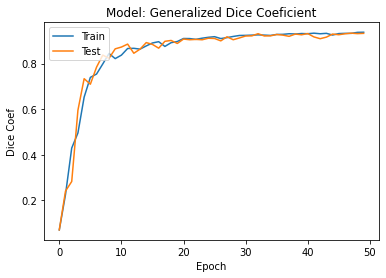

[0.8616082072257996, 0.8598546981811523, 0.8498887419700623, 0.8719313144683838, 0.8733348846435547, 0.859948456287384, 0.854036808013916, 0.8691770434379578, 0.86441969871521, 0.8682174682617188]


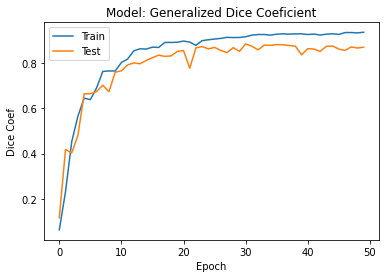

[0.9012251496315002, 0.856370210647583, 0.8721153736114502, 0.8729130029678345, 0.8792858123779297, 0.8663395643234253, 0.8654996752738953, 0.862815260887146, 0.8615716099739075, 0.8589990735054016]


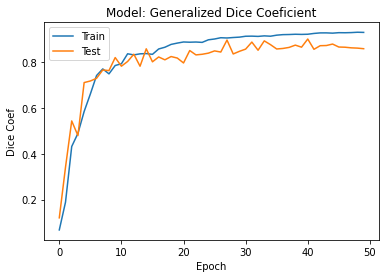

[0.9103236794471741, 0.9161185622215271, 0.906290590763092, 0.9138522744178772, 0.9169880151748657, 0.9153009057044983, 0.9175089001655579, 0.9169425368309021, 0.9161914587020874, 0.9145885109901428]


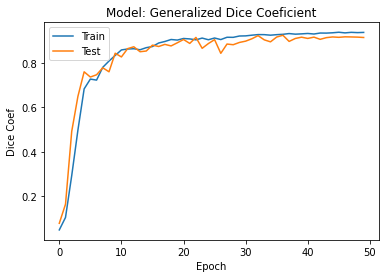

[0.90512615442276, 0.9094958305358887, 0.8892210125923157, 0.9051860570907593, 0.8907671570777893, 0.8918966054916382, 0.9028097987174988, 0.8980022668838501, 0.8974357843399048, 0.9019579291343689]


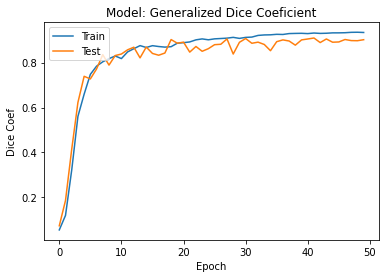

[0.9230343699455261, 0.9274188280105591, 0.922429084777832, 0.904448926448822, 0.9213250875473022, 0.918807327747345, 0.9252090454101562, 0.9206929206848145, 0.9193347096443176, 0.9208325743675232]


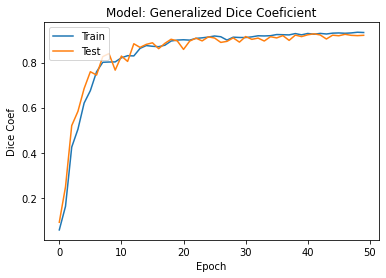

[0.9321659803390503, 0.9362460374832153, 0.9342607259750366, 0.9275004863739014, 0.9298182129859924, 0.9273767471313477, 0.9268007278442383, 0.9306634068489075, 0.9366968870162964, 0.9356710910797119]


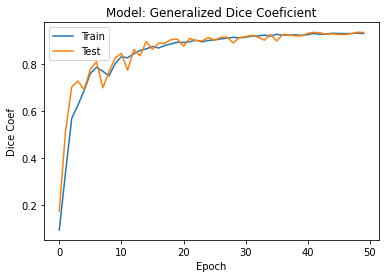

[0.9073662757873535, 0.8916985988616943, 0.8936343789100647, 0.9052639007568359, 0.8819594979286194, 0.8979684114456177, 0.8932474255561829, 0.900384247303009, 0.8902812600135803, 0.9040231108665466]


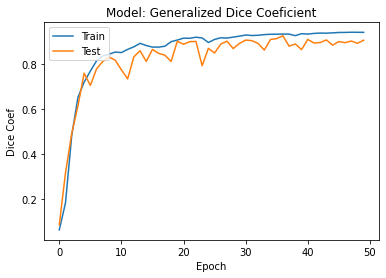

[0.8234526515007019, 0.7998183369636536, 0.8511718511581421, 0.8864728212356567, 0.8701959252357483, 0.861508309841156, 0.9033437371253967, 0.8728590607643127, 0.8651613593101501, 0.859407365322113]


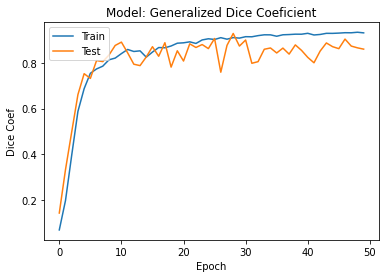

[0.8868362307548523, 0.8941512107849121, 0.8792287111282349, 0.8749971985816956, 0.8829190135002136, 0.9021070003509521, 0.8900911808013916, 0.8982552289962769, 0.8797898888587952, 0.8818928003311157]


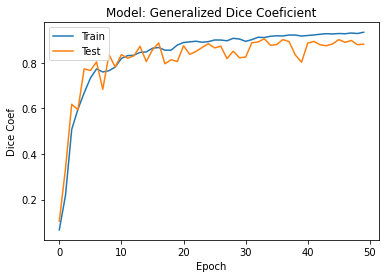

[0.9075489044189453, 0.907863199710846, 0.9134027361869812, 0.8996295928955078, 0.8992473483085632, 0.8905743956565857, 0.896476149559021, 0.8915229439735413, 0.9044394493103027, 0.8994539976119995]


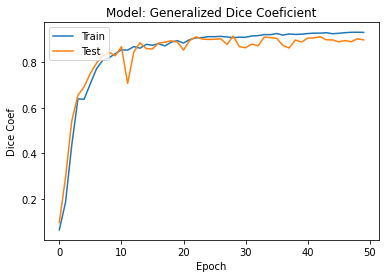

[0.9351547360420227, 0.9433068633079529, 0.9381198287010193, 0.937446653842926, 0.9421952366828918, 0.9419867992401123, 0.9419090151786804, 0.9426718354225159, 0.9424520134925842, 0.9429327845573425]


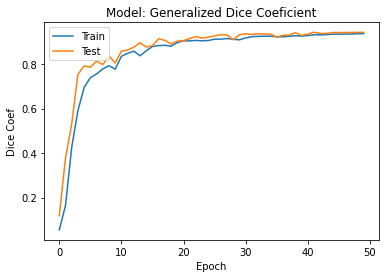

[0.9148246049880981, 0.9066205024719238, 0.9178367853164673, 0.9185017347335815, 0.9164583086967468, 0.9134759902954102, 0.9163714647293091, 0.9155281186103821, 0.9165142774581909, 0.9188353419303894]


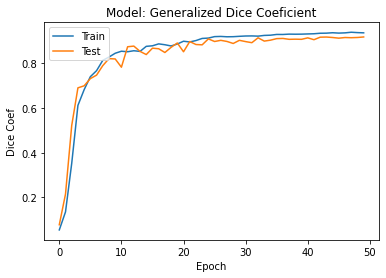

[0.9322126507759094, 0.9193482995033264, 0.9194598197937012, 0.9197706580162048, 0.9312306046485901, 0.9255664944648743, 0.92762690782547, 0.9325432181358337, 0.9348432421684265, 0.934868574142456]


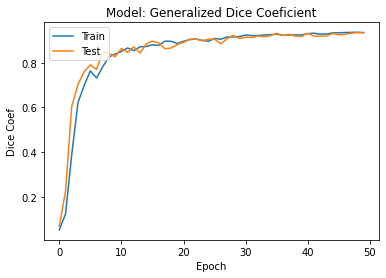

[0.9106409549713135, 0.9022073745727539, 0.9116377234458923, 0.913193941116333, 0.9193744659423828, 0.9165634512901306, 0.9433107376098633, 0.9418322443962097, 0.9416753649711609, 0.9410402774810791]


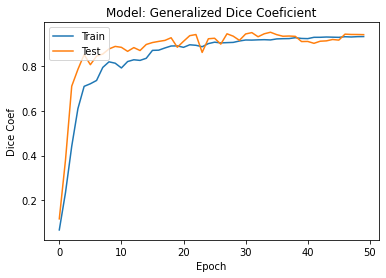

Dice 0.9050999482472738 +- 0.026938621039365784


In [4]:
val_gen_dice_coef_list = []
num_splits = 5
num_initializations = 3
epochs = 50
evaluation_epochs = int(0.2 * epochs)

for initialization in range(num_initializations):

    for fold in range(num_splits):
        train_patients, val_patients = get_split_deterministic(patients, fold=fold, num_splits=num_splits, random_state=initialization)

        train_dataset = SpleenDataset(train_patients, only_non_empty_slices=True)
        val_dataset = SpleenDataset(val_patients, only_non_empty_slices=True)

        train_dataloader = SpleenDataloader(train_dataset, batch_size, train_augmentation)
        val_dataloader = SpleenDataloader(val_dataset, batch_size, val_augmentation)

        model = build_net((*patch_size, 1), num_classes, fn_dict, net_list)

        # checkpoint_filepath = '/tmp/checkpoint'
        # model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        #     filepath=checkpoint_filepath,
        #     save_weights_only=True,
        #     monitor='val_gen_dice_coef',
        #     mode='max',
        #     save_best_only=True)

        # def learning_rate_fn(epoch, lr):
        #     return lr * 0.9

        # learning_rate_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_fn)

        def learning_rate_fn(epoch):
            initial_lr = 1e-3
            power = 0.9
            return float(initial_lr * (1 - (epoch / float(epochs))) ** power)
            
        lr_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_fn, verbose=False)

        history = model.fit(
            train_dataloader,
            validation_data=val_dataloader,
            epochs=epochs,
            verbose=0,
            callbacks=[
                lr_callback
                #model_checkpoint_callback,
                # learning_rate_scheduler_callback
            ]
        )
        
        # model.load_weights(checkpoint_filepath)

        print(history.history['val_gen_dice_coef'][-evaluation_epochs:])

        val_gen_dice_coef_list.extend(history.history['val_gen_dice_coef'][-evaluation_epochs:])

        # for patient in val_patients:
        #     patient_dataset = SpleenDataset([patient], only_non_empty_slices=True)
        #     patient_dataloader = SpleenDataloader(patient_dataset, 1, val_augmentation, shuffle=False)
        #     results = model.evaluate(patient_dataloader)
        #     val_gen_dice_coef_patient = results[-1]
        #     val_gen_dice_coef_list.append(val_gen_dice_coef_patient)

        #plotting the dice coef results (accuracy) as a function of the number of epochs
        plt.figure()
        plt.plot(history.history['gen_dice_coef'])
        plt.plot(history.history['val_gen_dice_coef'])
        plt.title('Model: Generalized Dice Coeficient')
        plt.ylabel('Dice Coef')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        #plotting the dice coeff results (loss function) as a function of the number of epochs
        # plt.figure()
        # plt.plot(history.history['loss'])
        # plt.plot(history.history['val_loss'])
        # plt.title('Model: Generalized Dice Coeficient')
        # plt.ylabel('Dice Loss')
        # plt.xlabel('Epoch')
        # plt.legend(['Train', 'Test'], loc='upper right')
        # plt.show()

mean_val_gen_dice_coef = (np.mean(val_gen_dice_coef_list))
std_val_gen_dice_coef = (np.std(val_gen_dice_coef_list))

print(f'Dice {mean_val_gen_dice_coef} +- {std_val_gen_dice_coef}')

In [5]:
#!tensorboard --logdir='./logs'